In [1]:
import qiskit
from qiskit.visualization import *

import numpy as np

import torch
import torch.nn.functional as F

## Quantum GAN implementation

In [2]:
def get_real_generator(theta):
    circuit = qiskit.QuantumCircuit(3, 1)
    
    circuit.h(0)
    circuit.rz(theta, 0)
    circuit.barrier()
    
    return circuit

def get_fake_generator():
    n_qubits = 3

    all_qubits = [i for i in range(n_qubits)]
    all_params_keys = ['g_x_0', 'g_x_1', 'g_x_2', \
                       'g_y_0', 'g_y_1', 'g_y_2', \
                       'g_z_0', 'g_z_1', 'g_z_2']

    params = {}
    for param in all_params_keys:
       params[param] = qiskit.circuit.Parameter(param)

    circuit = qiskit.QuantumCircuit(n_qubits, 1)
    
    circuit.h(0)

    circuit.rx(params['g_x_0'], 0)
    circuit.rx(params['g_x_1'], 1)
    circuit.ry(params['g_y_0'], 0)
    circuit.ry(params['g_y_1'], 1)
    circuit.rz(params['g_z_0'], 0)
    circuit.rz(params['g_z_1'], 1)
    
    circuit.cx(0, 1)

    circuit.rx(params['g_x_2'], 0)
    circuit.ry(params['g_y_2'], 0)
    circuit.rz(params['g_z_2'], 0)
    
    circuit.barrier()
    
    return circuit, params

def get_discriminator():
    n_qubits = 3

    all_qubits = [i for i in range(n_qubits)]
    all_params_keys = ['d_x_0', 'd_x_1', 'd_x_2', \
                       'd_y_0', 'd_y_1', 'd_y_2', \
                       'd_z_0', 'd_z_1', 'd_z_2']

    params = {}
    for param in all_params_keys:
       params[param] = qiskit.circuit.Parameter(param)

    circuit = qiskit.QuantumCircuit(n_qubits, 1)
    
    circuit.h(0)

    circuit.rx(params['d_x_0'], 0)
    circuit.rx(params['d_x_1'], 2)
    circuit.ry(params['d_y_0'], 0)
    circuit.ry(params['d_y_1'], 2)
    circuit.rz(params['d_z_0'], 0)
    circuit.rz(params['d_z_1'], 2)

    circuit.cx(0, 2)

    circuit.rx(params['d_x_2'], 2)
    circuit.ry(params['d_y_2'], 2)
    circuit.rz(params['d_z_2'], 2)
    
    circuit.barrier()
    
    return circuit, params

### Dataset 

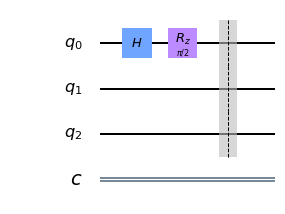

In [3]:
real_circuit = get_real_generator(np.pi / 2)
real_circuit.draw()

### Generator

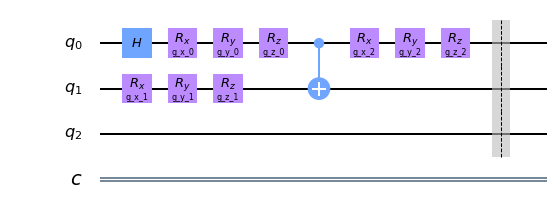

In [4]:
fake_circuit, fake_params = get_fake_generator()
fake_circuit.draw()

### Discriminator

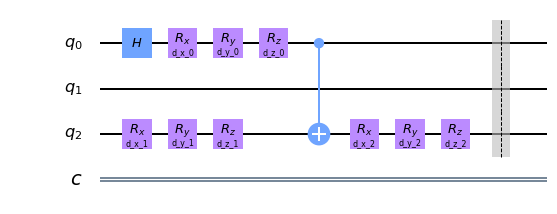

In [5]:
discriptor, discriptor_params = get_discriminator()
discriptor.draw()

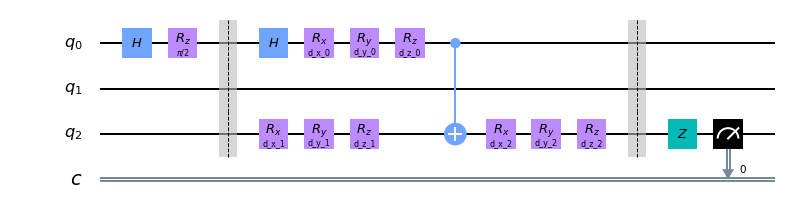

In [6]:
real_circuit = real_circuit.combine(discriptor)

real_circuit.z(2)
real_circuit.measure(2, 0)

real_circuit.draw()

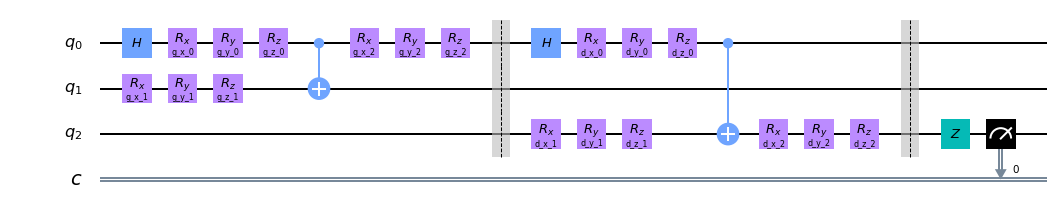

In [7]:
fake_circuit = fake_circuit.combine(discriptor)

fake_circuit.z(2)
fake_circuit.measure(2, 0)

fake_circuit.draw()

In [22]:
def get_probabilities(circuit, backend, iterations):
    def func(params):     
        job = qiskit.execute(circuit, backend, shots = iterations, parameter_binds = params)
        result = job.result().get_counts(circuit)

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        return counts / iterations
    return func

def loss_discriminator(fake_circuit, real_circuit, backend, iterations):
    P_f = get_probabilities(fake_circuit, backend, iterations)
    P_r = get_probabilities(real_circuit, backend, iterations)
    def func(gen_params, dis_params):
        return P_f([{**gen_params, **dis_params}]) - P_r([dis_params])
    return func

def loss_generator(fake_circuit, backend, iterations):
    P_f = get_probabilities(fake_circuit, backend, iterations)
    def func(gen_params, dis_params):
        return P_f([{**gen_params, **dis_params}])
    return func

In [24]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

W_g = {
    fake_params['g_x_0'] : np.pi / 3, 
    fake_params['g_x_1'] : np.pi / 3, 
    fake_params['g_x_2'] : np.pi / 3, 
    fake_params['g_y_0'] : np.pi / 3, 
    fake_params['g_y_1'] : np.pi / 3, 
    fake_params['g_y_2'] : np.pi / 4, 
    fake_params['g_z_0'] : np.pi / 4, 
    fake_params['g_z_1'] : np.pi / 4, 
    fake_params['g_z_2'] : np.pi / 4}
W_d = {
    discriptor_params['d_x_0'] : np.pi / 3, 
    discriptor_params['d_x_1'] : np.pi / 3, 
    discriptor_params['d_x_2'] : np.pi / 3, 
    discriptor_params['d_y_0'] : np.pi / 3, 
    discriptor_params['d_y_1'] : np.pi / 3, 
    discriptor_params['d_y_2'] : np.pi / 3, 
    discriptor_params['d_z_0'] : np.pi / 3, 
    discriptor_params['d_z_1'] : np.pi / 3, 
    discriptor_params['d_z_2'] : np.pi / 3}

In [27]:
loss_disc = loss_discriminator(fake_circuit, real_circuit, simulator, 1000)
loss_disc(W_g, W_d)

array([ 0.019, -0.019])

In [28]:
loss_gen = loss_generator(fake_circuit, simulator, 1000)
loss_gen(W_g, W_d)

array([0.079, 0.921])

#### Literature:
1. https://pennylane.ai/qml/demos/tutorial_QGAN.html